### This aims to classify the exosome staus based on a featureset derrived from the peaks.

Import Libraries

In [2]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from scipy.integrate import simps
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

Read the spectral data

In [3]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

In [4]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


In [ ]:
df.info()

Locate and correct the spikes

In [12]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if we has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=10)
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

Carry out baseline correction using Asymmetric Least Squares Smoothing to remove the background fluorescence from the spectra.

In [14]:
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

lam = 10 ** 3
p = 0.05
df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p))

Remove the noise from the spectra using Savitzky–Golay-filtering

In [15]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order))

## 1 Sample Example

In [16]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber  Absorbance     SurID         Status  \
7981415  210526-3-04     0   200.00000   3094.2837  210526-3  Hyperglycemia   
7981416  210526-3-04     1   200.68336   3109.5640  210526-3  Hyperglycemia   
7981417  210526-3-04     2   201.36674   3041.8801  210526-3  Hyperglycemia   
7981418  210526-3-04     3   202.05011   3033.1189  210526-3  Hyperglycemia   
7981419  210526-3-04     4   202.73349   3061.7734  210526-3  Hyperglycemia   
...              ...   ...         ...         ...       ...            ...   
7984045  210526-3-04  2630  1997.26650   1646.8857  210526-3  Hyperglycemia   
7984046  210526-3-04  2631  1997.94980   1655.2378  210526-3  Hyperglycemia   
7984047  210526-3-04  2632  1998.63330   1652.1541  210526-3  Hyperglycemia   
7984048  210526-3-04  2633  1999.31670   1644.7822  210526-3  Hyperglycemia   
7984049  210526-3-04  2634  2000.00000   1638.7900  210526-3  Hyperglycemia   

         Despiked_Absorbance  Baseline_Corrected_Ab

Find the peaks of each the differently smoothed spectra

In [17]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

raw_peaks, _ = find_peaks(x=sample['Absorbance'])
smooth_peaks, _ = find_peaks(x=sample['Smoothed_Absorbance'])
baseline_peaks, _ = find_peaks(x=sample['Baseline_Corrected_Absorbance'])
despiked_peaks, _ = find_peaks(x=sample['Despiked_Absorbance'])

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

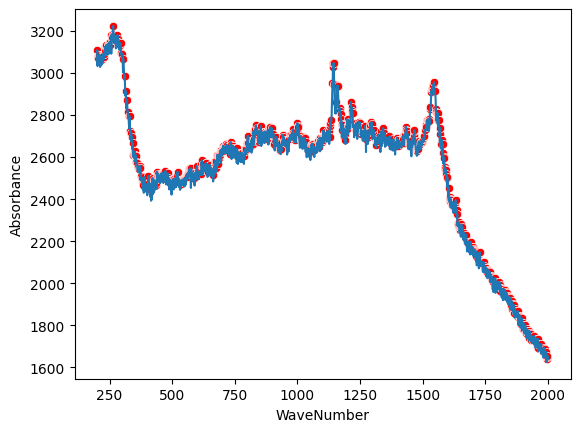

In [18]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[raw_peaks], x="WaveNumber", y="Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

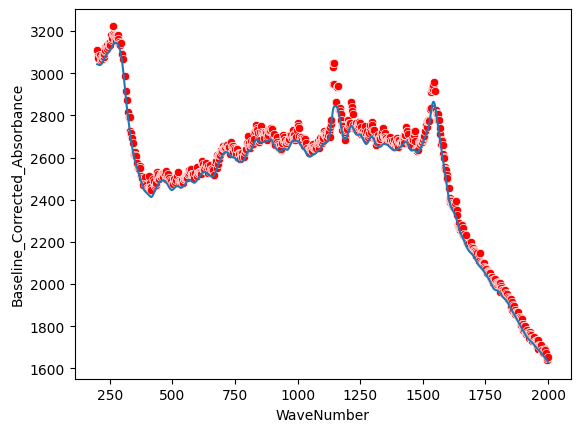

In [19]:
sns.lineplot(x="WaveNumber", y="Despiked_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[despiked_peaks], x="WaveNumber", y="Despiked_Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

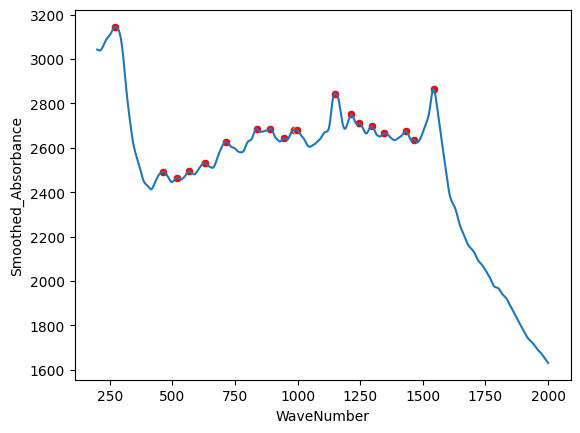

In [20]:
sns.lineplot(x="WaveNumber", y='Smoothed_Absorbance', data=sample)
sns.scatterplot(data=sample.iloc[baseline_peaks], x="WaveNumber", y="Baseline_Corrected_Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

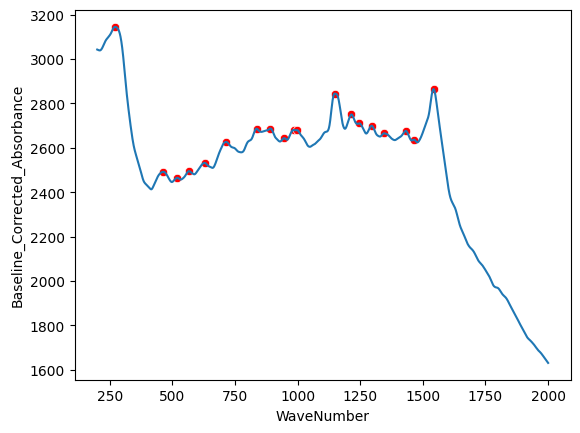

In [21]:
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[smooth_peaks], x="WaveNumber", y="Smoothed_Absorbance", color="red")

The average baseline corrected spectrum of each status

<AxesSubplot: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

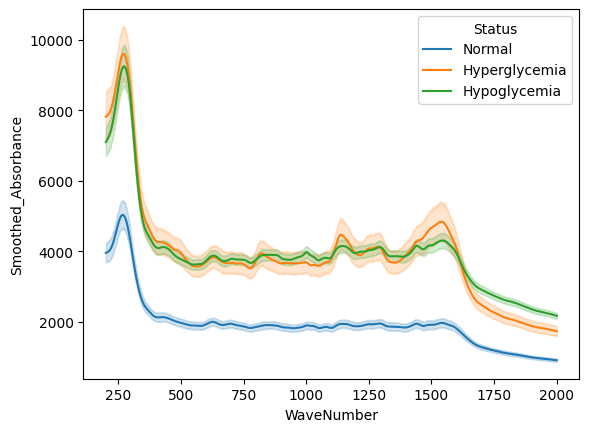

In [22]:
sns.lineplot(data=df, x='WaveNumber', y='Smoothed_Absorbance', hue='Status')

#### Machine Learning

In [23]:
spectra_df = df.drop(columns=['Absorbance', 'Baseline_Corrected_Absorbance'])

In [24]:
spectra_df = spectra_df.rename(columns={'Smoothed_Absorbance':'Absorbance'})

#### First we will look at the full wavelength.

Create a field for each wavelength.

In [25]:
wavelength_df = spectra_df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
wavelength_df.columns.name = None

Add the statuses back.

In [26]:
statuses = spectra_df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [27]:
wavelength_df.head()

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,2660.742142,2656.579384,2652.439885,2648.323647,2644.230668,2640.144967,2636.090645,2632.079765,2628.123254,2624.228788,...,1076.138234,1075.558369,1075.001964,1074.462980,1073.935406,1073.409926,1072.893138,1072.385040,1071.885633,Normal
201210-1-01,2962.622743,2956.056497,2949.500816,2942.955700,2936.421150,2929.889938,2923.372538,2916.873608,2910.398557,2903.953703,...,1256.109624,1256.774788,1257.462265,1258.167679,1258.885509,1259.604575,1260.332058,1261.067959,1261.812279,Normal
201210-1-02,3573.133562,3562.420768,3551.753514,3541.131799,3530.555624,3519.994031,3509.492577,3499.071897,3488.754117,3478.562652,...,2032.687673,2036.969847,2041.232001,2045.478888,2049.714326,2053.946669,2058.170203,2062.384929,2066.590847,Normal
201210-1-03,6420.443571,6566.552777,6711.166294,6854.284122,6995.906262,7137.443056,7276.785247,7412.958390,7545.080037,7672.277553,...,1695.951043,1695.031516,1694.121874,1693.219244,1692.319427,1691.415614,1690.512134,1689.608988,1688.706176,Normal
201210-1-04,3461.850490,3455.322563,3448.802206,3442.289420,3435.784203,3429.279675,3422.785361,3416.306078,3409.847649,3403.417300,...,1720.386637,1719.901161,1719.460119,1719.053353,1718.670199,1718.291913,1717.931321,1717.588423,1717.263219,Normal


##### 1. Training a Random Forest and Extra Trees Classifer on the whole spectrum.

In [28]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [29]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [30]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8512 +/- 0.0218
ExtraTreesClassifier Cross-Validation Accuracy: 0.8805 +/- 0.0184


#### 2. Using Peak Statistics

This uses statistical properties of the peaks in each sample to be used as additional features.

In [31]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    # peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

In [32]:
print(len(peaks))
print(len(widths))
print(len(prominences))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

60378
60378
60378


/tmp/ipykernel_15204/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_15204/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [33]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Despiked_Absorbance,Absorbance,PeakWidths,PeakProminences
243,201210-1-00,243,366.05923,201210-1,Normal,1849.8983,1838.967736,11.241177,1.680522
372,201210-1-00,372,454.21411,201210-1,Normal,1745.1431,1737.806985,20.821801,2.533121
476,201210-1-00,476,525.28473,201210-1,Normal,1698.3502,1695.937813,27.575649,6.423165
609,201210-1-00,609,616.17310,201210-1,Normal,1797.3893,1793.031752,56.889969,114.582771
726,201210-1-00,726,696.12756,201210-1,Normal,1838.5846,1790.465794,47.353488,127.067562


Standard Deviation of the Absorbances appears to have a positive affect on accuracy.

In [34]:
# Create a new DataFrame for the summary statistics
peak_stats = peaks_df.groupby('SpecID').agg({
    'Absorbance': ['mean', 'std', 'count', 'max', 'min'],
    'PeakWidths': ['mean', 'std', 'max', 'min'],
    'PeakProminences': ['mean', 'std', 'max', 'min']
}).reset_index()

# Flatten the multi-level columns and customize the names
peak_stats.columns = ['SpecID',
                      'PeakAbsorbance_mean', 'PeakAbsorbance_std', 'PeakAbsorbance_count', 'PeakAbsorbance_max', 'PeakAbsorbance_min',
                      'PeakWidths_mean', 'PeakWidths_std', 'PeakWidths_max', 'PeakWidths_min',
                      'PeakProminences_mean', 'PeakProminences_std', 'PeakProminences_max', 'PeakProminences_min']

In [35]:
peak_stats = pd.merge(peak_stats, statuses, on='SpecID')
peak_stats = peak_stats.set_index('SpecID')
peak_stats = peak_stats.fillna(False)

In [36]:
peak_stats.head()

,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,PeakProminences_std,PeakProminences_max,PeakProminences_min,Status
SpecID,,,,,,,,,,,,,,
201210-1-00,1564.608494,179.532990,22,1838.967736,1095.604317,33.012231,30.964040,116.531105,4.445955,23.266015,38.533348,127.067562,0.010945,Normal
201210-1-01,1763.670603,194.665601,21,2028.411973,1256.284976,36.736149,36.131082,141.320235,0.770091,32.410617,46.538828,146.464742,0.001426,Normal
201210-1-02,2191.347353,235.289616,18,2977.812305,1871.199314,47.413053,41.633435,165.964809,4.544830,120.380093,252.180997,1033.369193,0.085697,Normal
201210-1-03,3247.653373,1732.477839,17,8662.126544,2266.404564,40.007533,23.074929,83.426549,6.324263,342.978960,577.661293,2241.682974,0.309934,Normal
201210-1-04,2264.675813,257.491075,18,3172.931351,1850.154376,53.498900,58.207152,239.335118,5.374095,53.206094,88.403865,374.541969,0.105615,Normal


In [37]:
# Splitting the dataframe into features (X) and target variable (y)
X = peak_stats.drop(['Status'], axis=1)
y = peak_stats['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8174 +/- 0.0184
ExtraTreesClassifier Cross-Validation Accuracy: 0.8325 +/- 0.0209


Combine these peak statistics with the full wavelength

In [38]:
stats_and_spectrum = peak_stats.merge(wavelength_df.drop(columns='Status'), on='SpecID')

In [39]:
stats_and_spectrum.head()

,PeakAbsorbance_mean,PeakAbsorbance_std,PeakAbsorbance_count,PeakAbsorbance_max,PeakAbsorbance_min,PeakWidths_mean,PeakWidths_std,PeakWidths_max,PeakWidths_min,PeakProminences_mean,...,1993.8496,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1564.608494,179.532990,22,1838.967736,1095.604317,33.012231,30.964040,116.531105,4.445955,23.266015,...,1076.745802,1076.138234,1075.558369,1075.001964,1074.462980,1073.935406,1073.409926,1072.893138,1072.385040,1071.885633
201210-1-01,1763.670603,194.665601,21,2028.411973,1256.284976,36.736149,36.131082,141.320235,0.770091,32.410617,...,1255.468916,1256.109624,1256.774788,1257.462265,1258.167679,1258.885509,1259.604575,1260.332058,1261.067959,1261.812279
201210-1-02,2191.347353,235.289616,18,2977.812305,1871.199314,47.413053,41.633435,165.964809,4.544830,120.380093,...,2028.380670,2032.687673,2036.969847,2041.232001,2045.478888,2049.714326,2053.946669,2058.170203,2062.384929,2066.590847
201210-1-03,3247.653373,1732.477839,17,8662.126544,2266.404564,40.007533,23.074929,83.426549,6.324263,342.978960,...,1696.880925,1695.951043,1695.031516,1694.121874,1693.219244,1692.319427,1691.415614,1690.512134,1689.608988,1688.706176
201210-1-04,2264.675813,257.491075,18,3172.931351,1850.154376,53.498900,58.207152,239.335118,5.374095,53.206094,...,1720.923568,1720.386637,1719.901161,1719.460119,1719.053353,1718.670199,1718.291913,1717.931321,1717.588423,1717.263219


In [40]:
# Splitting the dataframe into features (X) and target variable (y)
X = stats_and_spectrum.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = stats_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8581 +/- 0.0193
ExtraTreesClassifier Cross-Validation Accuracy: 0.8798 +/- 0.0180


#### 3. Creating a uniform Peak Featureset

This aims to create a featureset using peaks within wavenumber intervals.

First get the peak properties

In [41]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    #peak_index, _ = find_peaks(x=group['Absorbance'], distance=152, prominence=42, width=6)
    peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

In [42]:
print(len(peaks))
print(len(widths))
print(len(prominences))
peaks_df['PeakWidths'] = widths
peaks_df['PeakProminences'] = prominences

60378
60378
60378


/tmp/ipykernel_15204/1918292714.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakWidths'] = widths
/tmp/ipykernel_15204/1918292714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['PeakProminences'] = prominences


In [43]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Despiked_Absorbance,Absorbance,PeakWidths,PeakProminences
243,201210-1-00,243,366.05923,201210-1,Normal,1849.8983,1838.967736,11.241177,1.680522
372,201210-1-00,372,454.21411,201210-1,Normal,1745.1431,1737.806985,20.821801,2.533121
476,201210-1-00,476,525.28473,201210-1,Normal,1698.3502,1695.937813,27.575649,6.423165
609,201210-1-00,609,616.17310,201210-1,Normal,1797.3893,1793.031752,56.889969,114.582771
726,201210-1-00,726,696.12756,201210-1,Normal,1838.5846,1790.465794,47.353488,127.067562


Assign Peaks to bins of a fixed wavelength interval.

In [44]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

/tmp/ipykernel_15204/464682704.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df['Bin'] = peaks_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))


In [45]:
peaks_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Despiked_Absorbance,Absorbance,PeakWidths,PeakProminences,Bin
243,201210-1-00,243,366.05923,201210-1,Normal,1849.8983,1838.967736,11.241177,1.680522,350-375
372,201210-1-00,372,454.21411,201210-1,Normal,1745.1431,1737.806985,20.821801,2.533121,450-475
476,201210-1-00,476,525.28473,201210-1,Normal,1698.3502,1695.937813,27.575649,6.423165,525-550
609,201210-1-00,609,616.17310,201210-1,Normal,1797.3893,1793.031752,56.889969,114.582771,600-625
726,201210-1-00,726,696.12756,201210-1,Normal,1838.5846,1790.465794,47.353488,127.067562,675-700


Set the bins as columns with the peak absrobances, widths and prominences as the values.
If no peaks appear in a bin the value is set to False.
If multiple peaks appear their properties are aggregated.

In [46]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = peaks_df.pivot_table(index='SpecID', columns='Bin', values=['Absorbance', 'PeakWidths', 'PeakProminences'], aggfunc='max')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = peaks_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(False, inplace=True)

In [47]:
peak_bins.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,PeakWidths_775-800,PeakWidths_800-825,PeakWidths_825-850,PeakWidths_850-875,PeakWidths_875-900,PeakWidths_900-925,PeakWidths_925-950,PeakWidths_950-975,PeakWidths_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1658.578333,False,1619.442023,False,False,1561.70057,False,1515.312512,False,1532.226342,...,False,10.535987,False,10.244074,116.531105,False,False,False,False,Normal
201210-1-01,1828.964739,False,1778.629127,False,False,1724.818425,False,1692.840861,False,False,...,False,False,False,8.061369,False,114.678687,6.881845,False,False,Normal
201210-1-02,2203.342274,2223.411153,False,False,False,2150.468092,False,False,False,False,...,False,False,False,False,False,46.47195,False,False,False,Normal
201210-1-03,False,False,2639.009803,False,False,False,3054.571126,False,False,2544.423366,...,False,False,False,False,False,68.058547,False,False,83.426549,Normal
201210-1-04,2178.570737,False,2156.651946,False,False,False,False,2229.105567,False,False,...,False,False,False,False,5.374095,100.717433,False,False,False,Normal


In [48]:
# Splitting the dataframe into features (X) and target variable (y)
X = peak_bins.drop(['Status'], axis=1)
y = peak_bins['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8381 +/- 0.0249
ExtraTreesClassifier Cross-Validation Accuracy: 0.8759 +/- 0.0209


Merge with the full spectrum.

In [49]:
bins_and_spectrum = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')

/tmp/ipykernel_15204/2474809401.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bins_and_spectrum = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')


In [50]:
bins_and_spectrum.head()

,Absorbance_1000-1025,Absorbance_1025-1050,Absorbance_1050-1075,Absorbance_1075-1100,Absorbance_1100-1125,Absorbance_1125-1150,Absorbance_1150-1175,Absorbance_1175-1200,Absorbance_1200-1225,Absorbance_1225-1250,...,1993.8496,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1658.578333,False,1619.442023,False,False,1561.70057,False,1515.312512,False,1532.226342,...,1076.745802,1076.138234,1075.558369,1075.001964,1074.462980,1073.935406,1073.409926,1072.893138,1072.385040,1071.885633
201210-1-01,1828.964739,False,1778.629127,False,False,1724.818425,False,1692.840861,False,False,...,1255.468916,1256.109624,1256.774788,1257.462265,1258.167679,1258.885509,1259.604575,1260.332058,1261.067959,1261.812279
201210-1-02,2203.342274,2223.411153,False,False,False,2150.468092,False,False,False,False,...,2028.380670,2032.687673,2036.969847,2041.232001,2045.478888,2049.714326,2053.946669,2058.170203,2062.384929,2066.590847
201210-1-03,False,False,2639.009803,False,False,False,3054.571126,False,False,2544.423366,...,1696.880925,1695.951043,1695.031516,1694.121874,1693.219244,1692.319427,1691.415614,1690.512134,1689.608988,1688.706176
201210-1-04,2178.570737,False,2156.651946,False,False,False,False,2229.105567,False,False,...,1720.923568,1720.386637,1719.901161,1719.460119,1719.053353,1718.670199,1718.291913,1717.931321,1717.588423,1717.263219


In [51]:
# Splitting the dataframe into features (X) and target variable (y)
X = bins_and_spectrum.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = bins_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8804 +/- 0.0136
ExtraTreesClassifier Cross-Validation Accuracy: 0.8946 +/- 0.0171


In [52]:
# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Training the classifier on the entire dataset
    clf.fit(X, y)
    
    # Displaying the cross-validation results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')
    
    # Displaying the top 10 most important features
    feature_importances = clf.feature_importances_
    indices = np.argsort(feature_importances)[::-1][:10]  # Get indices of top 10 features
    top_features = X.columns[indices]
    print(f'Top 10 Features: {top_features}')

RandomForestClassifier Cross-Validation Accuracy: 0.8804 +/- 0.0136
Top 10 Features: Index(['PeakProminences_500-525', 'PeakProminences_275-300',
       'PeakWidths_250-275', 'PeakWidths_500-525', 'Absorbance_500-525',
       '1958.9977', '1989.7494', '1999.3167', '1997.9498',
       'PeakProminences_1100-1125'],
      dtype='object')
ExtraTreesClassifier Cross-Validation Accuracy: 0.8946 +/- 0.0171
Top 10 Features: Index(['Absorbance_500-525', 'PeakWidths_275-300', 'Absorbance_1025-1050',
       'Absorbance_275-300', 'PeakWidths_250-275', 'PeakProminences_275-300',
       'PeakWidths_500-525', 'Absorbance_250-275', '265.60364', '1909.795'],
      dtype='object')


Try the raw spectrum with the baseline corrected peaks.

In [53]:
spectra_df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

#Create a field for each wavelength.
wavelength_df = spectra_df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
wavelength_df.columns.name = None
#Add the statuses back.
statuses = spectra_df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [54]:
raw_spec_baseline_bins = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')

/tmp/ipykernel_15204/983759271.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  raw_spec_baseline_bins = peak_bins.merge(wavelength_df.drop(columns='Status'), on='SpecID')


In [55]:
# Splitting the dataframe into features (X) and target variable (y)
X = raw_spec_baseline_bins.drop(['Status'], axis=1)
X.columns = X.columns.astype(str)
y = bins_and_spectrum['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.8828 +/- 0.0151
ExtraTreesClassifier Cross-Validation Accuracy: 0.8995 +/- 0.0179


In [56]:
raw_spec_baseline_bins.to_csv("../../data/raw_spec_and_max_bins.csv")